## The problem

So the question is that you are a player of a slot machine and you have 3 games to play (A,B and C). You as the player want to play the game that has the highest probability of winning in order to get as many wins as possible. The problem is that you don’t know the posterior distributions of each of these games, so you cant select the best game from the start. Instead we have to learn which game is the best by playing the games, then exploit the best game.

So your prior belief is that you have no information about any of these games and so to represent that we use a beta distribution with alpha = 1 and Beta = 1 which is a uniform distribution


In [159]:
import scipy
from scipy.stats import binom
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats 
from scipy.special import beta

## Visualizing our initial beliefs with no data

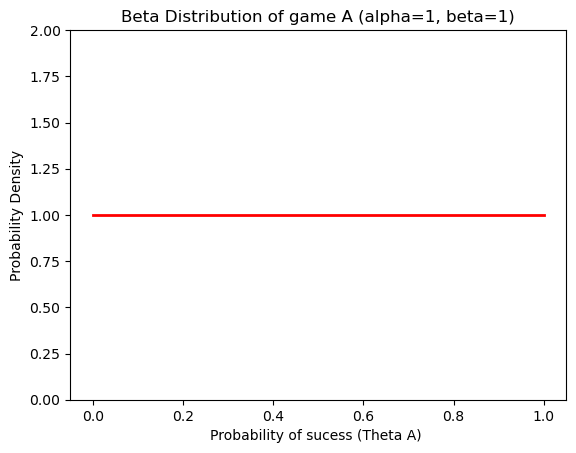

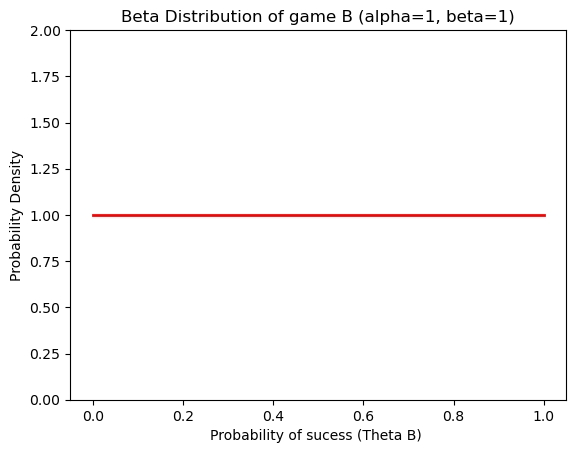

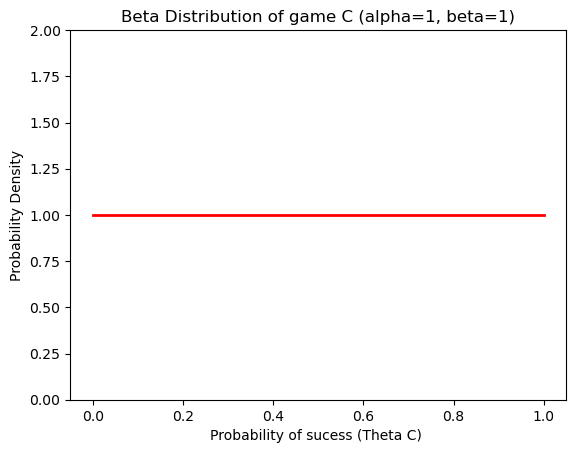

In [160]:
# Representing our prior beliefs of each game

alpha = [1,1,1]
beta_value = [1,1,1]
pdfs = []
game = ["A","B","C"]

# Plot each game's PDF (Beta distribution): 

for i in range(3):
    x = np.linspace(0, 1, 1000)
    pdfs.append(stats.beta.pdf(x,alpha[i],beta_value[i]))
    plt.plot(x, pdfs[i], 'r-', lw=2, label='Beta PDF')
    plt.title(f'Beta Distribution of game {game[i]} (alpha={alpha[i]}, beta={beta_value[i]})')
    plt.xlabel(f'Probability of sucess (Theta {game[i]}) ')
    plt.ylabel('Probability Density')
    plt.ylim(0,2)
    plt.show()



## Visualizing the simulated posteriors

Now, we do not have any data, therefore, to get data we will simulate it by choosing a theta (probability of success) for each game. We will also show how the true posteriors will look like given the thetas we chose for
each game. To do this we will just initialize alpha and beta values as well as get the simulated number of sucesses
k and choose a simulated n.

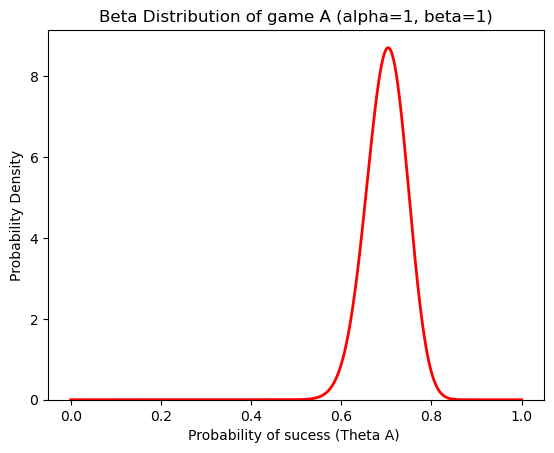

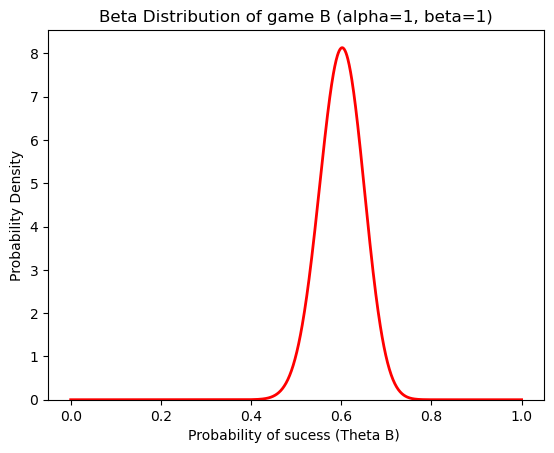

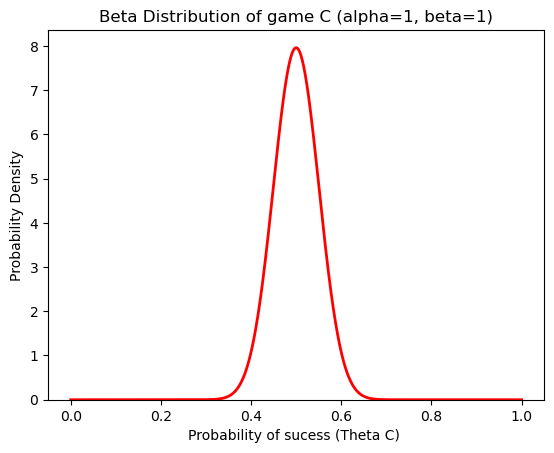

In [162]:
game = ["A","B","C"]
alpha = [1,1,1]
beta_value = [1,1,1]
theta= [0.7,0.6,0.5]
pdfs = []
n = 100
parameter_domain = np.linspace(0, 1, 1000)

for i in range(3):
    pdfs.append(stats.beta(a=(theta[i] * n)+alpha[i]-1,b=n-(theta[i] * n)+beta_value[i]-1).pdf(parameter_domain))
    plt.plot(parameter_domain, pdfs[i], 'r-', lw=2, label='Beta PDF')
    plt.title(f'Beta Distribution of game {game[i]} (alpha={alpha[i]}, beta={beta_value[i]})')
    plt.xlabel(f'Probability of sucess (Theta {game[i]}) ')
    plt.ylabel('Probability Density')
    plt.ylim(0)
    plt.show()

So now we know which game is the best (game A) according to the simulated posterior distributions. However, the program does not know that and so now the goal now is to use Bayesian statistics to also get the same result by updating the prior so it concentrates to the simulated posterior which in this case will be the posterior-Beta distribution of game A (Red). It should do this by choosing the optimal combination of exploration and exploitation. 

## Determining a strategy in choosing which game to play in the most efficient manner

So when deciding which game to play, we want to pick the game that we think has the highest probability of success. Remember the program doesnt know which game is the best so it will have to explore all 3 games first. However, the
way in which it explores is dependent on the simulated data that is observed.

In the beginning we have no simulated data, so to determine which game we think is best we will sample from our current beliefs which are the 3 prior distribtions that are initially uniform distributions. To pick a game, we
will pick the one with the highest probability. Remember this is our belief that game A will win and we will
check it with our simulated data.

At this point each game has a 1/3 chance of being picked since they all have the exact same prior distributions. However this will change when obtain data (i.e play games).

**Understanding the algorithm**

So to understand how this algorithm is working suppose we sample from our 3 initial prior distributions and game A gets picked since it has the highest probaility of success out of all the games (Our belief).

Now when you play game A, you either win or lose depending on the result of a bernoulli trial using p as the simulated probability of successes created.So if you win or lose, either way the prior distribution will get updated by n and x of game A changing.

Then, the algorithm will sample from the updated prior A, along with the initial priors of B and C. Again, either game A,B or C will get chosen as the game to play, however now the probability of choosing game A is higher (i.e has the highest theta out of all games) if game A won and lower if game A lost when we played it the first time. 

So here we can see how the simulated data changes which game we decide to play next. If game A won, it will take
note of that and update the posterior in a way (see code below), to favor the game getting chosen again.

The game will update based off the beta-binomial posterior distribution where n[j] is the number of times game
A,B or C is played and x[j] is the number of success for each of the games. The alphas and betas are intialized at 1

At the beginning, if the theta values of A,B and C are close together then it will explore games B and C relatively more than if theta A was 0.9 and theta B was 0.2 and theta C was 0.1 (See code below of the percentage of how much each game gets played if theta values change). The reason is simply because if theta A was say 0.7 (theta B and C are still 0.2 and 0.1), and game A got picked first it will more likely result in a failure compared to if theta A was 0.9 and hence will more likely explore the other games before getting A again and realizing its the best choice (See code below for the percenatge of each game played for different thetas)


**Understanding the different estimated probabilities when running the simulation multiple times**

Case 1:

If we see that game A's estimated probability of success is very close to the simulated probability of success and
the other game's estimated probability of success were not as close to their simulated probabilities then what happened is that game A got sampled quite a bit in the beginning and the game updated its prior and hence game
A got favored more to get chosen. 

However, due to the random nature of random sampling from probability distributions games B and C still get picked
but less than A and hence do not get updated as much as A

(See code below to understand how this works)

Case 2:

Sometimes B and C got played more than A, in the beginning and so their estimated probabilities of success were 
updated more than A, but then when the program chooses A later on, it will pick that up and begin updating its prior to favor choosing game A until eventually just exploiting A

In the end we know with a big enough N, the game with the highest simulated probability of success will have its estimated probability converge very closely to its simulated probaility of success. Due to nature of random sampling sometimes the other games will also converge closely to their simulated probability of success (but not as close as game A) and the intuition is provided above.

(See code below to understand how this works)


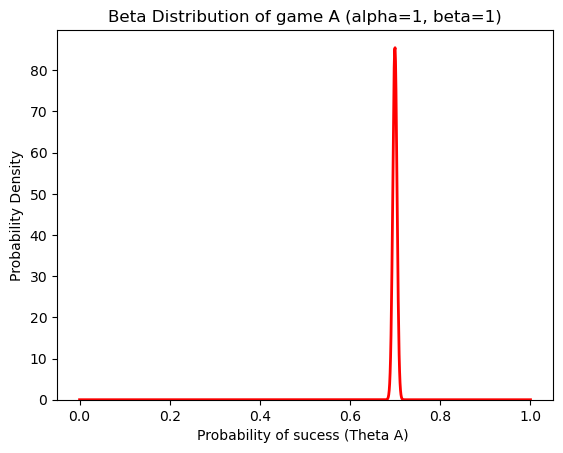

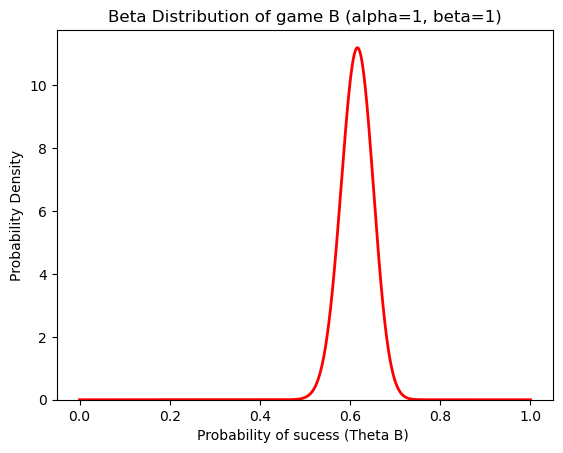

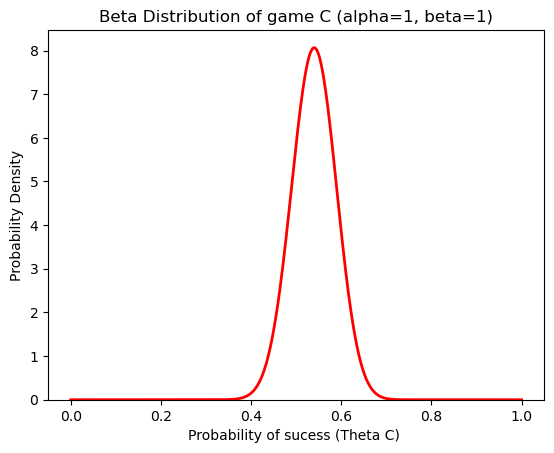

In [275]:
N = 10000
x = [0,0,0]
n = [0,0,0]
alpha = 1
beta_value = 1
alpha_values = [1,1,1]
beta_values = [1,1,1]
theta= [0.7,0.6,0.5]
game = ["A","B","C"]
parameter_domain = np.linspace(0, 1, 1000)
pdfs = []
lst_games = []

for _ in range(N):
    samples = [] # Sampling from priors and updated priors
    for j in range(3):
        sample = np.random.beta(a = x[j] + alpha , b = n[j] - x[j] + beta_value)
        samples.append(sample)
        
    
    if max(samples) == samples[0]: # game A is played and is either a win or a loss
        lst_games.append("A")
        x[0] = x[0] + np.random.binomial(n=1, p=theta[0])
        n[0] = n[0] + 1
        
    if max(samples) == samples[1]: # game B is played and is either a win or a loss
        lst_games.append("B")
        x[1] = x[1] + np.random.binomial(n=1, p=theta[1])
        n[1] = n[1] + 1
        
    if max(samples) == samples[2]: # game C is played and is either a win or a loss
        lst_games.append("C")
        x[2] = x[2] + np.random.binomial(n=1, p=theta[2])
        n[2] = n[2] + 1
    
    
for i in range(3):
    pdfs.append(stats.beta(a=x[i]+alpha_values[i],b=n[i]-x[i]+beta_values[i]).pdf(parameter_domain))
    plt.plot(parameter_domain, pdfs[i], 'r-', lw=2, label='Beta PDF')
    plt.title(f'Beta Distribution of game {game[i]} (alpha={alpha_values[i]}, beta={beta_values[i]})')
    plt.xlabel(f'Probability of sucess (Theta {game[i]}) ')
    plt.ylabel('Probability Density')
    plt.ylim(0)
    plt.show()

In [276]:
estimated_prob = []
for i in range(3):
    estimated_prob.append(x[i]/n[i])
    
estimated_prob

[0.6993309315491508, 0.6162162162162163, 0.54]

In [277]:
print(n)
print(x)

[9715, 185, 100]
[6794, 114, 54]


In [278]:
# This represents in percentage terms how much each game got played
percent_played = []
for i in range(3):
    percent_played.append(n[i]/N * 100) 
    
percent_played

[97.15, 1.8499999999999999, 1.0]

In [246]:
lst_games

['C',
 'C',
 'A',
 'B',
 'C',
 'C',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'A',
 'C',
 'A',
 'C',
 'C',
 'A',
 'A',
 'B',
 'C',
 'A',
 'C',
 'B',
 'A',
 'B',
 'A',
 'B',
 'A',
 'A',
 'C',
 'C',
 'C',
 'A',
 'A',
 'C',
 'C',
 'C',
 'A',
 'C',
 'A',
 'A',
 'C',
 'A',
 'C',
 'A',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'A',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'A',
 'C',
 'A',
 'B',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'B',
 'B',
 'C',
 'A',
 'A',
 'A',
 'B',
 'A',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'B',
 'A',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'A',
 'A',
 'A',
 'C',
 'A',
 'C',
 'A',
 'C',
 'A'